# ResNet-18 Implementation
This is an implementation of the ResNet-18 architecure trained and tested on the CIFAR-10 and FashionMNIST datasets

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision
from torchvision import datasets, transforms
from torchvision.models import resnet18
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import seaborn as sns
from sklearn.preprocessing import label_binarize

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


#### Function for printing sample images

In [15]:
def show_samples(dataset, dataset_name, n_samples=4):
    loader = torch.utils.data.DataLoader(dataset, batch_size=n_samples, shuffle=True)
    images, _ = next(iter(loader))

    plt.figure(figsize=(12, 3))
    for i in range(n_samples):
        plt.subplot(1, n_samples, i+1)
        img = images[i]

        if img.shape[0] == 1:  # grayscale
            plt.imshow(img[0], cmap='gray')
        else:
            plt.imshow(img.permute(1, 2, 0))

        # plt.title(f"{dataset_name} Sample {i+1}")
        plt.axis('off')
    plt.show()

#### Function for loss/training curves

In [3]:
def plot_history(history, best_metrics, dataset_name="Dataset"):
    epochs = range(1, len(history['train_loss']) + 1)
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'{dataset_name} - Loss over Epochs')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train Accuracy')
    plt.plot(epochs, history['val_acc'], label='Val Accuracy')
    plt.axhline(y=best_metrics['val_acc'], color='r', linestyle='--', label='Best Val Acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title(f'{dataset_name} - Accuracy over Epochs')
    plt.legend()
    plt.tight_layout()
    plt.show()

#### Confusion matrix function

In [4]:
def plot_confusion_matrix(true_labels, predicted_labels, dataset_name="Dataset"):
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'{dataset_name} - Confusion Matrix')
    plt.show()

#### Prepare datasets, transforms, loaders, and 90/10 train-val split

In [5]:
# Transforms
transform_c10 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

transform_fmnist = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.286,), (0.353,))
])

# Load datasets
dataset_c10 = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_c10)
test_dataset_c10 = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_c10)

dataset_fmnist = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform_fmnist)
test_dataset_fmnist = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform_fmnist)

# 90/10 train-validation split function
def split_dataset(dataset, val_ratio=0.1):
    n_total = len(dataset)
    n_val = int(n_total * val_ratio)
    n_train = n_total - n_val
    return random_split(dataset, [n_train, n_val])

train_dataset_c10, val_dataset_c10 = split_dataset(dataset_c10)
train_dataset_fmnist, val_dataset_fmnist = split_dataset(dataset_fmnist)

batch_size = 128

# Dataloaders
train_loader_c10 = DataLoader(train_dataset_c10, batch_size=batch_size, shuffle=True)
val_loader_c10 = DataLoader(val_dataset_c10, batch_size=batch_size, shuffle=False)
test_loader_c10 = DataLoader(test_dataset_c10, batch_size=batch_size, shuffle=False)

train_loader_fmnist = DataLoader(train_dataset_fmnist, batch_size=batch_size, shuffle=True)
val_loader_fmnist = DataLoader(val_dataset_fmnist, batch_size=batch_size, shuffle=False)
test_loader_fmnist = DataLoader(test_dataset_fmnist, batch_size=batch_size, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


#### CIFAR-10 Sample Images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


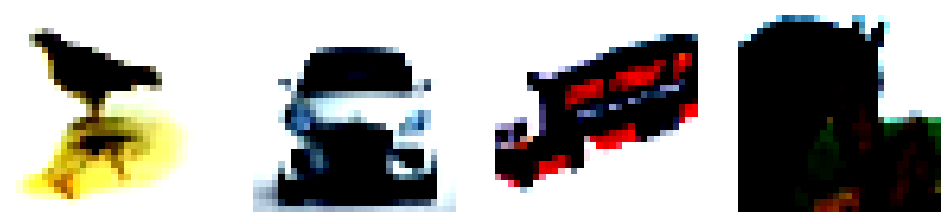

In [16]:
show_samples(train_dataset_c10, "CIFAR10 Training Samples")

#### FashionMNIST Sample Images

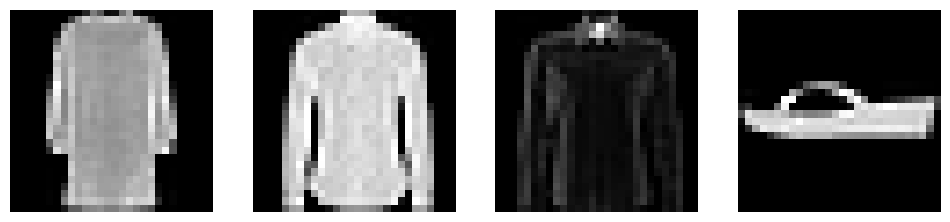

In [17]:
show_samples(train_dataset_fmnist, "FashionMNIST Training Samples")

#### Define ResNet18 model constructor

In [8]:
def get_resnet18_model(num_classes=10, in_channels=3):
    model = resnet18(weights=None)
    if in_channels != 3:
        model.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model.to(device)


#### Training and validation functions

In [9]:
def train_one_epoch(model, dataloader, criterion, optimizer):
    model.train()
    running_loss = 0
    correct = 0
    total = 0
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == targets).sum().item()
        total += targets.size(0)
    return running_loss / total, 100 * correct / total

def validate(model, dataloader, criterion):
    model.eval()
    running_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == targets).sum().item()
            total += targets.size(0)
    return running_loss / total, 100 * correct / total

def train_model(model, train_loader, val_loader, num_epochs=5, lr=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_val_acc = 0
    best_model_wts = None

    for epoch in range(num_epochs):
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer)
        val_loss, val_acc = validate(model, val_loader, criterion)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_wts = model.state_dict()

        print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    if best_model_wts:
        model.load_state_dict(best_model_wts)

    return history, {'train_acc': max(history['train_acc']), 'val_acc': best_val_acc}

#### Evaluation function with precision, recall, f1, AU-ROC metrics

In [10]:
def evaluate_model(model, dataloader, num_classes, dataset_name="Dataset"):
    model.eval()
    all_preds = []
    all_targets = []
    all_probs = []

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            probs = nn.functional.softmax(outputs, dim=1)
            _, preds = torch.max(probs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.numpy())
            all_probs.extend(probs.cpu().numpy())

    acc = accuracy_score(all_targets, all_preds) * 100
    precision = precision_score(all_targets, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_targets, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_targets, all_preds, average='weighted', zero_division=0)

    try:
        binary_targets = label_binarize(all_targets, classes=list(range(num_classes)))
        auroc = roc_auc_score(binary_targets, all_probs, average='weighted', multi_class='ovr')
    except Exception as e:
        auroc = float('nan')

    print(f"{dataset_name} Test Accuracy: {acc:.2f}%")
    print(f"{dataset_name} Precision (weighted): {precision:.4f}")
    print(f"{dataset_name} Recall (weighted): {recall:.4f}")
    print(f"{dataset_name} F1 Score (weighted): {f1:.4f}")
    print(f"{dataset_name} AU-ROC (weighted): {auroc:.4f}")

    plot_confusion_matrix(all_targets, all_preds, dataset_name=dataset_name)

Training CIFAR10 model...
Epoch [1/25] Train Loss: 1.4109, Train Acc: 49.14% | Val Loss: 1.2360, Val Acc: 56.78%
Epoch [2/25] Train Loss: 1.0001, Train Acc: 64.75% | Val Loss: 0.9549, Val Acc: 66.74%
Epoch [3/25] Train Loss: 0.8049, Train Acc: 71.79% | Val Loss: 0.8994, Val Acc: 68.18%
Epoch [4/25] Train Loss: 0.6809, Train Acc: 76.10% | Val Loss: 0.8265, Val Acc: 71.14%
Epoch [5/25] Train Loss: 0.5739, Train Acc: 80.13% | Val Loss: 0.8483, Val Acc: 71.36%
Epoch [6/25] Train Loss: 0.4802, Train Acc: 83.10% | Val Loss: 0.7514, Val Acc: 75.26%
Epoch [7/25] Train Loss: 0.3888, Train Acc: 86.37% | Val Loss: 0.8707, Val Acc: 73.76%
Epoch [8/25] Train Loss: 0.3156, Train Acc: 88.80% | Val Loss: 0.8871, Val Acc: 73.66%
Epoch [9/25] Train Loss: 0.2551, Train Acc: 90.96% | Val Loss: 0.9298, Val Acc: 73.70%
Epoch [10/25] Train Loss: 0.1988, Train Acc: 93.08% | Val Loss: 1.0084, Val Acc: 74.36%
Epoch [11/25] Train Loss: 0.1666, Train Acc: 94.16% | Val Loss: 1.0200, Val Acc: 74.10%
Epoch [12/25] T

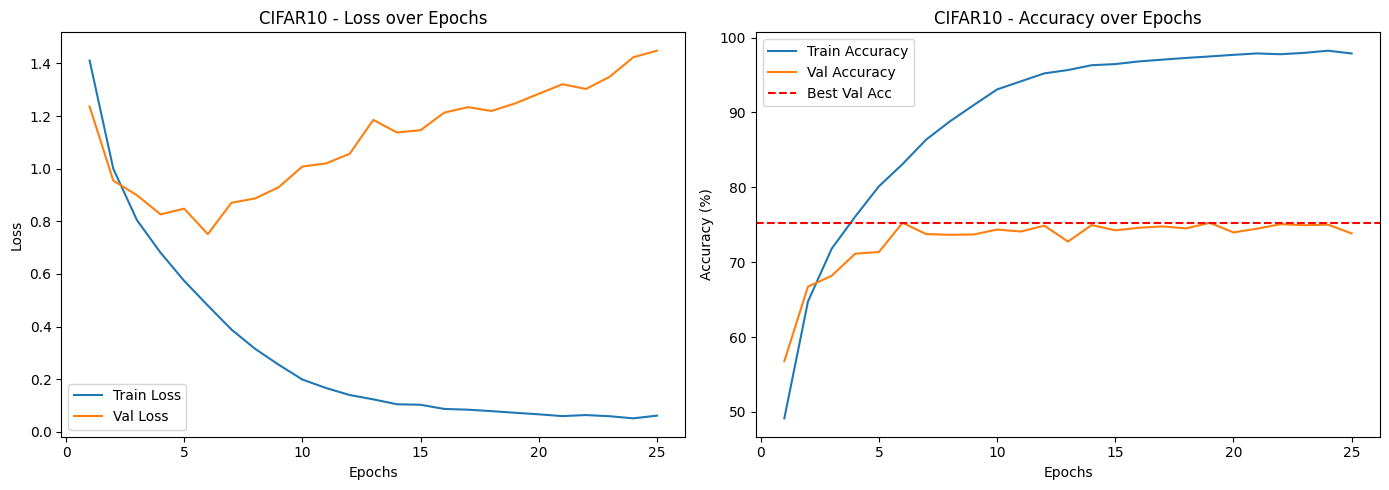


Evaluating CIFAR10 Test Set
CIFAR10 Test Accuracy: 74.04%
CIFAR10 Precision (weighted): 0.7475
CIFAR10 Recall (weighted): 0.7404
CIFAR10 F1 Score (weighted): 0.7408
CIFAR10 AU-ROC (weighted): 0.9611


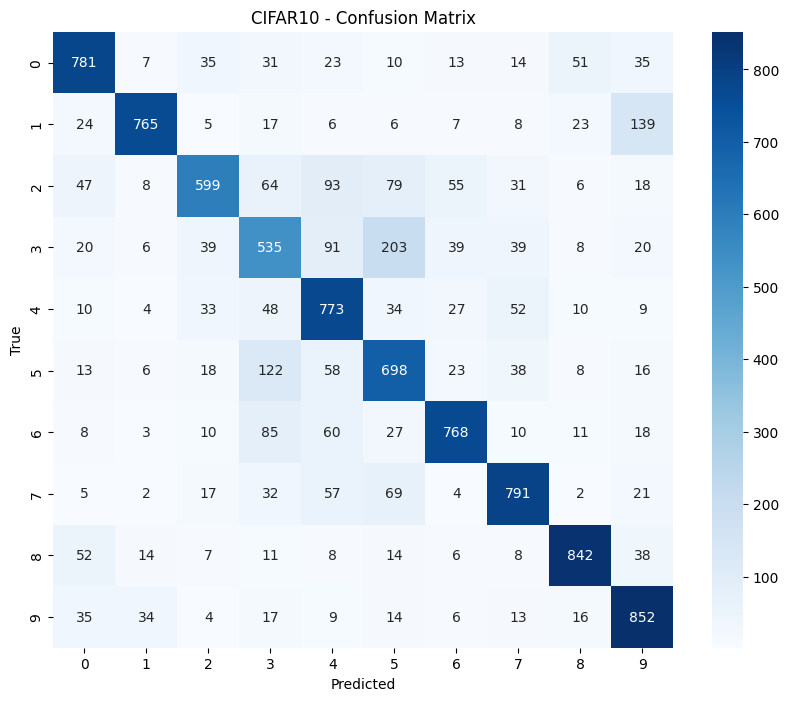

In [13]:
num_classes_c10 = 10
model_c10 = get_resnet18_model(num_classes=num_classes_c10, in_channels=3)

print("Training CIFAR10 model...")
history_c10, best_metrics_c10 = train_model(model_c10, train_loader_c10, val_loader_c10, num_epochs=25, lr=0.001)
plot_history(history_c10, best_metrics_c10, dataset_name="CIFAR10")

print("\nEvaluating CIFAR10 Test Set")
evaluate_model(model_c10, test_loader_c10, num_classes_c10, dataset_name="CIFAR10")


Training FashionMNIST model...
Epoch [1/25] Train Loss: 0.4274, Train Acc: 84.31% | Val Loss: 0.3361, Val Acc: 87.85%
Epoch [2/25] Train Loss: 0.2983, Train Acc: 89.03% | Val Loss: 0.3472, Val Acc: 87.58%
Epoch [3/25] Train Loss: 0.2586, Train Acc: 90.56% | Val Loss: 0.3264, Val Acc: 88.07%
Epoch [4/25] Train Loss: 0.2287, Train Acc: 91.50% | Val Loss: 0.2798, Val Acc: 89.98%
Epoch [5/25] Train Loss: 0.2102, Train Acc: 92.24% | Val Loss: 0.2615, Val Acc: 90.57%
Epoch [6/25] Train Loss: 0.1887, Train Acc: 92.92% | Val Loss: 0.2819, Val Acc: 90.02%
Epoch [7/25] Train Loss: 0.1742, Train Acc: 93.49% | Val Loss: 0.2665, Val Acc: 90.68%
Epoch [8/25] Train Loss: 0.1540, Train Acc: 94.16% | Val Loss: 0.2845, Val Acc: 90.22%
Epoch [9/25] Train Loss: 0.1422, Train Acc: 94.72% | Val Loss: 0.2725, Val Acc: 91.47%
Epoch [10/25] Train Loss: 0.1312, Train Acc: 95.08% | Val Loss: 0.2958, Val Acc: 91.18%
Epoch [11/25] Train Loss: 0.1169, Train Acc: 95.59% | Val Loss: 0.2870, Val Acc: 91.17%
Epoch [12/

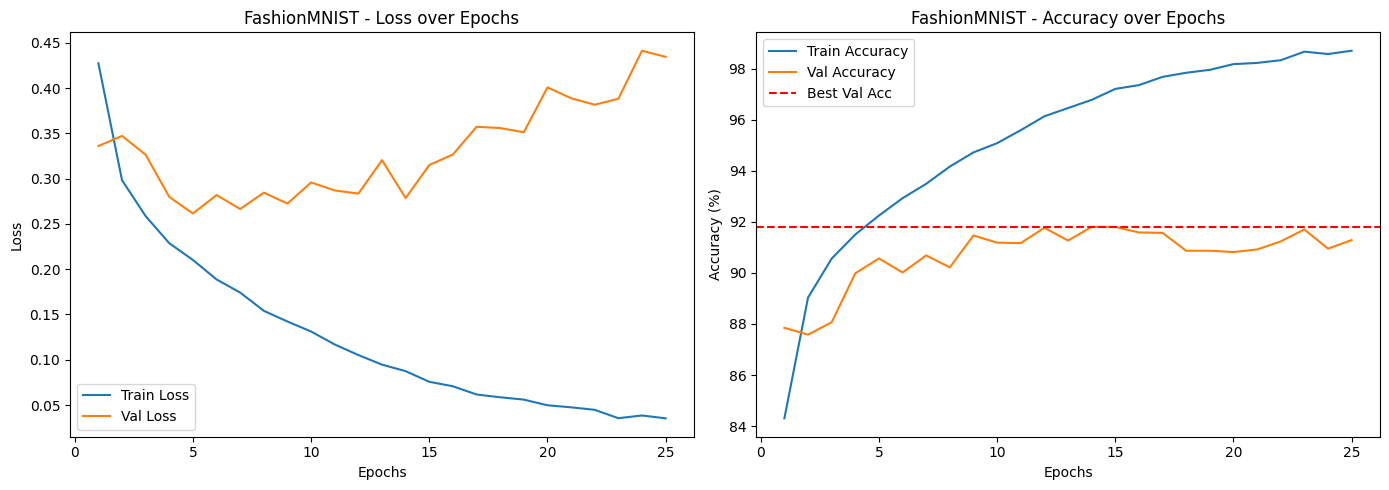


Evaluating FashionMNIST Test Set
FashionMNIST Test Accuracy: 90.49%
FashionMNIST Precision (weighted): 0.9070
FashionMNIST Recall (weighted): 0.9049
FashionMNIST F1 Score (weighted): 0.9053
FashionMNIST AU-ROC (weighted): 0.9924


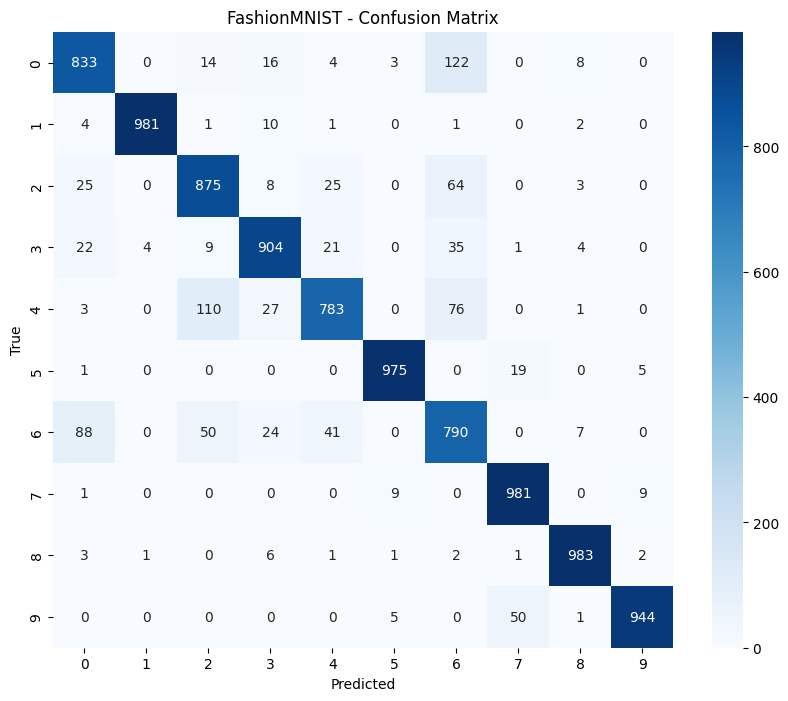

In [14]:
num_classes_fmnist = 10
model_fmnist = get_resnet18_model(num_classes=num_classes_fmnist, in_channels=1)

print("Training FashionMNIST model...")
history_fmnist, best_metrics_fmnist = train_model(model_fmnist, train_loader_fmnist, val_loader_fmnist, num_epochs=25, lr=0.001)
plot_history(history_fmnist, best_metrics_fmnist, dataset_name="FashionMNIST")

print("\nEvaluating FashionMNIST Test Set")
evaluate_model(model_fmnist, test_loader_fmnist, num_classes_fmnist, dataset_name="FashionMNIST")
